# This notebook makes Figure 1 of the main manuscript

# It requires a pickle file that is produced by running Backtracing.ipynb

In [1]:
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy
import pickle
import cartopy.feature as cfea
import fnmatch
import os
import netCDF4 as nc
from scipy.spatial import KDTree
import matplotlib as mpl
import numpy.ma as ma
import matplotlib.ticker as mticker

/tmp/ipykernel_13878/943298430.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
(pmw_lon,pmw_lat,pmw_data,floes_df,dfs,dates)= pickle.load(open('../data/f1map.p','rb'))

pmw_f = 'ice_conc_sh_polstere-100_multi_202204221200.nc'
pmw_d = Dataset(f'../data/OSISAF_pmw/{pmw_f}')
pmw_data = np.array(pmw_d['ice_conc'][0].copy())
pmw_data[pmw_data>0.5] = 2
pmw_data[pmw_data<0] = 1
pmw_data[pmw_data<0.5] = np.nan

In [4]:
files = fnmatch.filter(os.listdir('../data/ice_age/'),'*.nc')
ds = nc.Dataset('../data/ice_age/ECICE-IcetypesUncorrected-20220416.nc')

tice = np.array(ds['TOTAL_ICE'][:])
fyi = np.array(ds['FYI'][:])
myi = np.array(ds['MYI'][:])#.values().copy()
myi[tice == 0] = np.nan

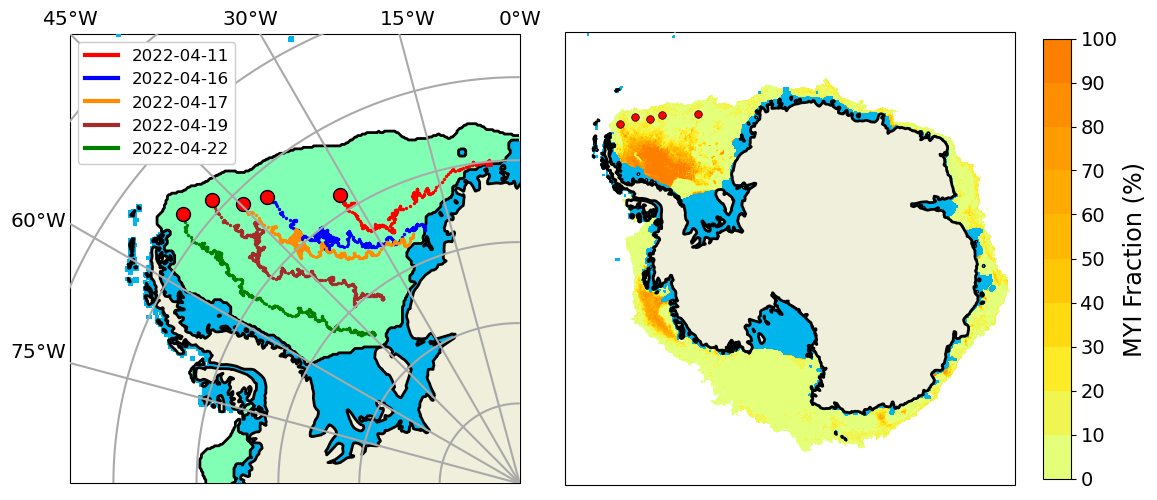

In [7]:
#now with blanking out of zero values

i=0
fig, (ax,ax2) = plt.subplots(1, 2, figsize = (14, 8), 
                       subplot_kw = {'projection': ccrs.SouthPolarStereo()})


######################## RIGHT HAND PANEL AX2 ########################


ax2.set_extent([-180, 180, -90, -62], crs=ccrs.PlateCarree())

# ax = plt.axes(projection=ccrs.SouthPolarStereo())
markersize = .3

extent = [-180, 180, -90, -75]




cmap = plt.cm.Wistia  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (.5, .5, .5, 1.0)
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(0, 100, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


icol = ax2.pcolormesh(ds['LON'],
                      ds['LAT'],
                      myi,
#                       vmin = 0, vmax = 100, 
#                       cmap='Wistia',
                      cmap=cmap, norm=norm,
                      transform=ccrs.PlateCarree())







df = pd.read_csv('../data/floe_coords.csv',parse_dates=['dt'])
# df

scat = ax2.scatter(df['lon'],
                  df['lat'],
                  transform=ccrs.PlateCarree(),
                  marker='o',
                  color='r',
                  edgecolor='k',
                  linewidths=0.5,
                  s=30,
                  zorder=15,)


pmw_mels = pmw_data.copy()
pmw_mels[pmw_mels>1] = np.nan



mesh = ax2.pcolormesh(pmw_lon,pmw_lat,
                     pmw_mels,
                         cmap='rainbow',
                     transform=ccrs.PlateCarree(),
                    vmin=0,vmax=4,zorder=15)

ax2.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=100,linewidth=2)


ax2.plot([180, 180], [-90, -85],
         color=cfea.COLORS['land'],
         linewidth=4,
         transform=ccrs.PlateCarree(),
         zorder=10e9)




######################## LEFT HAND PANEL AX ########################


ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=9,linewidth=2)

ax.set_extent([-80, -10, -90, -62], ccrs.PlateCarree())

scat = ax.scatter(floes_df['lon'],
                  floes_df['lat'],
                  transform=ccrs.PlateCarree(),
                  marker='o',
                  color='r',
                  edgecolor='k',
                  s=100,
                 zorder=16,
                 )



colors = ['r','b','darkorange','brown','green']    

for df_traj, date, color in zip(dfs,dates,colors):

    scat = ax.scatter(df_traj['lon'],
                      df_traj['lat'],
                      c=color,
#                       c='r',
                      transform=ccrs.PlateCarree(),
                      marker='o',
                      s=2,
                      zorder=15)
    
    ax.plot([],[],color=color,label=date,lw=3)
    

lon2d_greater = ma.masked_greater(np.array(pmw_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(pmw_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(pmw_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(pmw_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(np.array(pmw_d['ice_conc'][0]), mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(np.array(pmw_d['ice_conc'][0]), mask=lon2d_greater.mask)


cont_Great = ax.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0],
                  transform=ccrs.PlateCarree(),
                  zorder=6,
                    linewidths=[2],
                  colors=['k'])


mesh = ax.pcolormesh(pmw_lon,pmw_lat,
                     pmw_data,
                         cmap='rainbow',
                     transform=ccrs.PlateCarree(),
                    vmin=0,vmax=4,zorder=5)



gl = ax.gridlines(zorder=1000,color='darkgrey',linewidth=1.5)

gl.xlabel_style = {'size': 15, 'color': 'k'}

gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xlocator = mticker.FixedLocator(np.arange(180,-181,-15))

# gl.ylabels_left = True
# gl.xlabels_top = True

xy_annos = [(-0.07,0.28),(-0.07,0.57),(0,1.02),(0.4,1.02),(0.75,1.02),(1,1.02)]
xy_text = [75,60,45,30,15,0]

st = '$\degree$W'

for pos,txt in zip(xy_annos,xy_text):
    ax.annotate(xy=(pos[0],pos[1]),text=f'{txt}{st}',xycoords='axes fraction',fontsize='x-large',ha='center')

ax.legend(loc='upper left',fontsize='12',facecolor='white',framealpha=1).set_zorder(10_0000) 

overleaf_dir = '/home/robbie/Dropbox/Apps/Overleaf/KuKa_Weddell/main_figs'

gl.xlabel_style = {'size': 15, 'color': 'k'}

fig.subplots_adjust(right=0.8,wspace=0.1)
p_ax = fig.add_axes([0.82, 0.22, 0.02,0.55])
cb = fig.colorbar(icol, cax = p_ax)
cb.set_label( 'MYI Fraction (%)',fontsize='xx-large')
cb.set_ticks(np.arange(0,101,10),labels=np.arange(0,101,10),fontsize=14)

plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/KuKa Weddell/Figures/F1.png',bbox_inches='tight')
plt.savefig('../figures/F1.png',bbox_inches='tight')

plt.show()